# VAE for Bitcoin  

I am interested in extracting structural moifs from timeseries. Here, I am going to investigate using a variational autoencoder for this. I will build the model and then spend some time trying to understand which parts of the timeseries activate the model the most (these must be the important parts...).  


In [1]:
library(ggplot2)
library(data.table)
library(keras)
install_keras()

data_file_pattern <- "../Data/%s/poloniex/PoloniexChartData_USDT_BTC.csv"
raw_data <- rbindlist(
    lapply(2015:2018, function (yr) {
        tmp <- fread(sprintf(data_file_pattern, yr))
        tmp[, Datestamp := as.POSIXct(Datestamp)]
        tmp[, HourlyStamp := as.POSIXct(strftime(Datestamp, format = "%Y-%m-%d %H:00:00"))]
        tmp[, DailyStamp := as.POSIXct(strftime(Datestamp, format = "%Y-%m-%d"))]
        tmp[, HourlyMaxClose := max(close), by = "HourlyStamp"]
        return(tmp)
    })
)

str(raw_data)
head(raw_data[order(date, decreasing = FALSE)], n = 10)

Creating virtualenv for TensorFlow at  ~/.virtualenvs/r-tensorflow 
Installing TensorFlow ...

Installation complete.

Classes ‘data.table’ and 'data.frame':	119106 obs. of  12 variables:
 $ close          : num  225 225 225 225 225 240 240 244 244 244 ...
 $ date           : int  1424372400 1424373300 1424374200 1424375100 1424376000 1424376900 1424377800 1424378700 1424379600 1424380500 ...
 $ high           : num  225 225 225 225 225 240 240 244 244 244 ...
 $ low            : num  225 225 225 225 225 225 240 244 244 244 ...
 $ open           : num  225 225 225 225 225 225 240 244 244 244 ...
 $ quoteVolume    : num  0.00444 0 0 0 0 ...
 $ volume         : num  1 0 0 0 0 ...
 $ weightedAverage: num  225 225 225 225 225 ...
 $ Datestamp      : POSIXct, format: "2015-02-19 19:00:00" "2015-02-19 19:15:00" ...
 $ HourlyStamp    : POSIXct, format: "2015-02-19 19:00:00" "2015-02-19 19:00:00" ...
 $ DailyStamp     : POSIXct, format: "2015-02-19" "2015-02-19" ...
 $ HourlyMaxClose : num  22

close,date,high,low,open,quoteVolume,volume,weightedAverage,Datestamp,HourlyStamp,DailyStamp,HourlyMaxClose
225,1424372400,225,225,225,0.00444444,0.999999,225.0000,2015-02-19 19:00:00,2015-02-19 19:00:00,2015-02-19,225
225,1424373300,225,225,225,0.00000000,0.000000,225.0000,2015-02-19 19:15:00,2015-02-19 19:00:00,2015-02-19,225
225,1424374200,225,225,225,0.00000000,0.000000,225.0000,2015-02-19 19:30:00,2015-02-19 19:00:00,2015-02-19,225
225,1424375100,225,225,225,0.00000000,0.000000,225.0000,2015-02-19 19:45:00,2015-02-19 19:00:00,2015-02-19,225
225,1424376000,225,225,225,0.00000000,0.000000,225.0000,2015-02-19 20:00:00,2015-02-19 20:00:00,2015-02-19,244
240,1424376900,240,225,225,0.12862524,30.624650,238.0921,2015-02-19 20:15:00,2015-02-19 20:00:00,2015-02-19,244
240,1424377800,240,240,240,0.00000000,0.000000,240.0000,2015-02-19 20:30:00,2015-02-19 20:00:00,2015-02-19,244
244,1424378700,244,244,244,0.06004601,14.651226,244.0000,2015-02-19 20:45:00,2015-02-19 20:00:00,2015-02-19,244
244,1424379600,244,244,244,0.00000000,0.000000,244.0000,2015-02-19 21:00:00,2015-02-19 21:00:00,2015-02-19,244
244,1424380500,244,244,244,0.00000000,0.000000,244.0000,2015-02-19 21:15:00,2015-02-19 21:00:00,2015-02-19,244


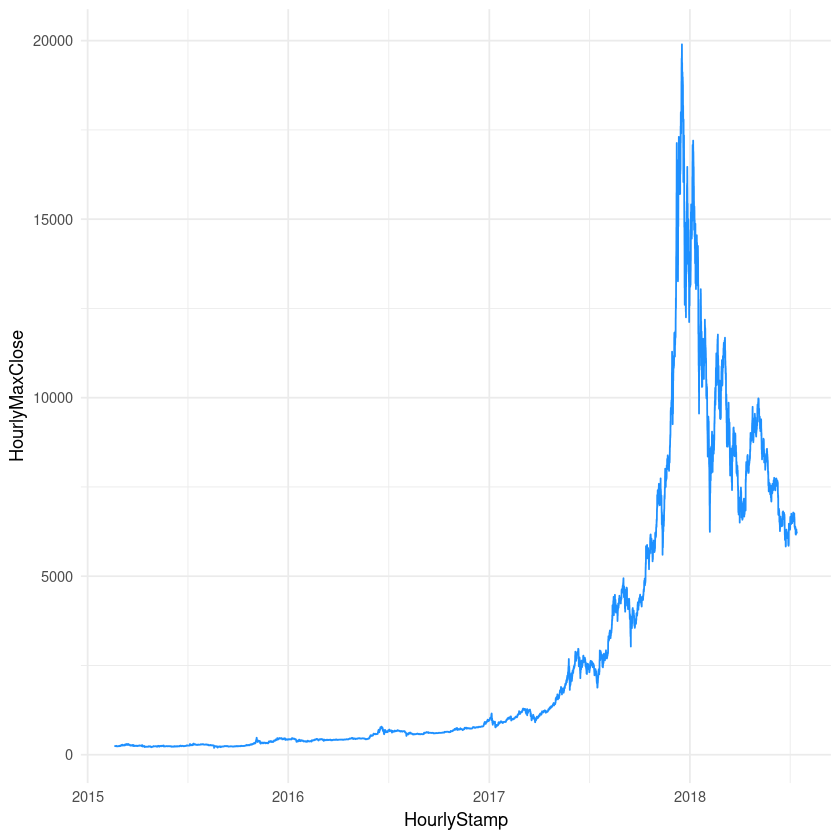

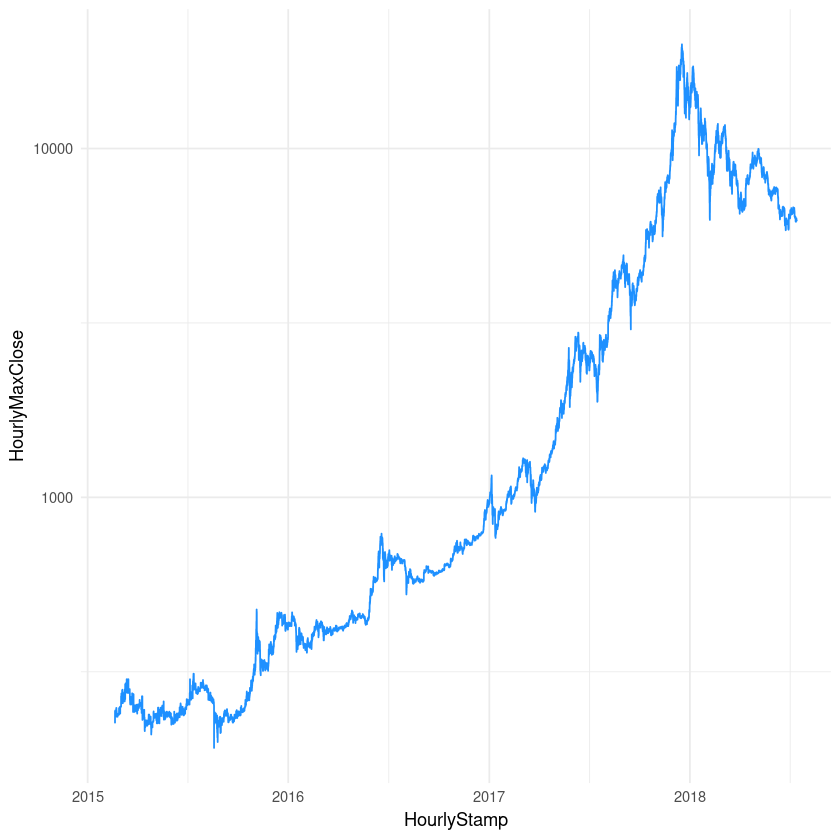

In [2]:
g <- ggplot(raw_data, aes(x = HourlyStamp, y = HourlyMaxClose)) +
    geom_line(colour = "dodgerblue") +
    theme_minimal()

print(g)
print(g + scale_y_log10())

I am going to work with 3 week windows. Below, I have created a generator function which extracts the closing price in 4-day blocks:

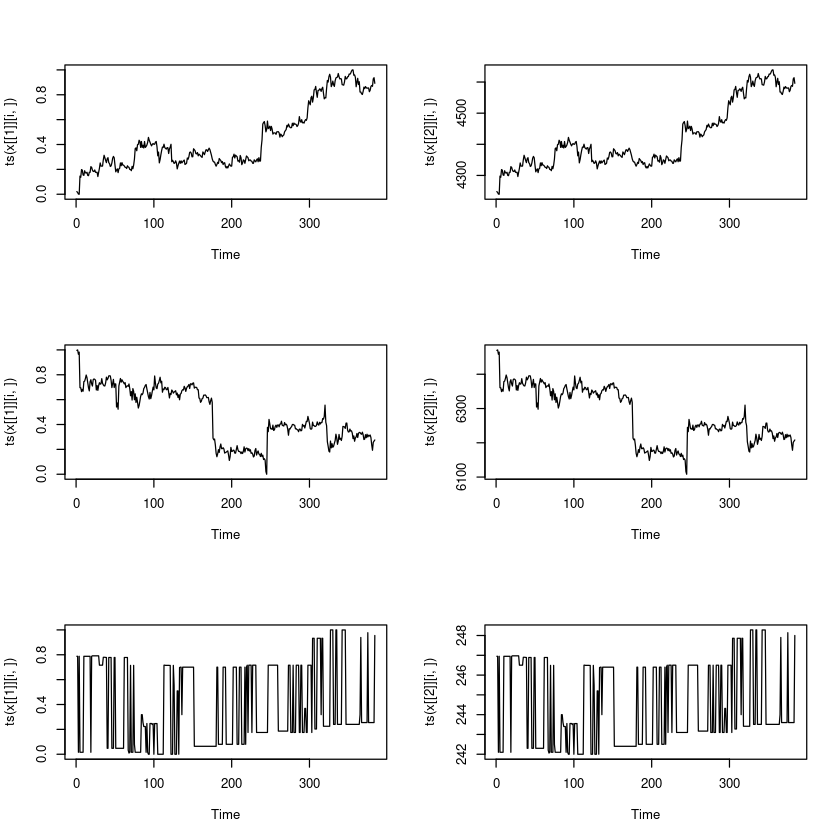

In [15]:
get_window <- function (input_data, period = 4, batch_size = 64) {
    
    
    function () {
        
        xs <- sample(nrow(input_data), batch_size, replace = TRUE)
        #dimensions <- (4 * 24 * 7 * period)
        dimensions <- (4 * 24 * period)
        
        original <- matrix(0, nrow = batch_size, ncol = dimensions)
        sequences <- matrix(0, nrow = batch_size, ncol = dimensions)
        
        for (x in 1:length(xs)) {
            start_ <- input_data[xs[x], Datestamp]
            #end_ <- start_ + (period * 7 * 24 * 60 * 60)
            end_ <- start_ + (period * 24 * 60 * 60)
            
            z <- input_data[Datestamp >= start_ & Datestamp <= end_, close]
            original[x, ] <- z[1:dimensions]
            z <- (z - min(z)) / (max(z) - min(z))
            
            # Pad with trailing zeros if necessary
            if (length(z) < dimensions) {
                z_ <- rep(0, dimensions)
                z_[1:length(z)] <- z
                
                z <- z_
            }

            sequences[x, ] <- z[1:dimensions]
        }
        return (list(sequences, original))
    }
}
factory <- get_window(raw_data)
x <- factory()
par(mfrow=c(3, 2))
for (i in 1:3) {
    plot(ts(x[[1]][i, ]))
    plot(ts(x[[2]][i, ]))
}
par(mfrow = c(1, 1))

That looks like it is working. Let's now setup the model...

In [128]:
factory <- get_window(raw_data)
period <- 4
original_dim <- 384
latent_dim <- 4L
intermediate_dim <- 128L
epochs <- 50L
epsilon_std <- 1.0

# Model definition --------------------------------------------------------

x <- layer_input(shape = c(original_dim))
h <- layer_dense(x, intermediate_dim, activation = "relu")
z_mean <- layer_dense(h, latent_dim)
z_log_var <- layer_dense(h, latent_dim)

sampling <- function(arg){
  z_mean <- arg[, 1:(latent_dim)]
  z_log_var <- arg[, (latent_dim + 1):(2 * latent_dim)]
  
  epsilon <- k_random_normal(
    shape = c(k_shape(z_mean)[[1]]), 
    mean=0.,
    stddev=epsilon_std
  )
  
  z_mean + k_exp(z_log_var/2)*epsilon
}

# note that "output_shape" isn't necessary with the TensorFlow backend
z <- layer_concatenate(list(z_mean, z_log_var)) %>% 
  layer_lambda(sampling)

# we instantiate these layers separately so as to reuse them later
decoder_h <- layer_dense(units = intermediate_dim, activation = "relu")
decoder_mean <- layer_dense(units = original_dim, activation = "sigmoid")
h_decoded <- decoder_h(z)
x_decoded_mean <- decoder_mean(h_decoded)

# end-to-end autoencoder
vae <- keras_model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder <- keras_model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input <- layer_input(shape = latent_dim)
h_decoded_2 <- decoder_h(decoder_input)
x_decoded_mean_2 <- decoder_mean(h_decoded_2)
generator <- keras_model(decoder_input, x_decoded_mean_2)


vae_loss <- function(x, x_decoded_mean){
  xent_loss <- (original_dim/1.0)*loss_binary_crossentropy(x, x_decoded_mean)
  kl_loss <- -0.5*k_mean(1 + z_log_var - k_square(z_mean) - k_exp(z_log_var), axis = -1L)
  xent_loss + kl_loss
}

vae %>% compile(optimizer = "rmsprop", loss = vae_loss)

In [141]:
x_train <- do.call(rbind, lapply(1:200, function (x) factory()[[1]]))
x_test <- do.call(rbind, lapply(1:50, function (x) factory()[[1]]))

dim(x_train)
x_train[1:10, 1:10]
summary(rowSums(x_train))
                                
dim(x_test)
x_test[1:10, 1:10]
summary(rowSums(x_test))

[1] 12800   384

0.52841619,0.48216878,0.48216878,0.48216878,0.47833446,0.47643729,0.44836906,0.44836906,0.44836906,0.44836906
0.48756262,0.48756262,0.48756262,0.48756262,0.48756262,0.48756262,0.48756262,0.48756262,0.48756262,0.48756262
0.23970390,0.27466644,0.29744333,0.29554080,0.28153724,0.29408055,0.32162191,0.38540627,0.37585265,0.27965454
0.05592972,0.05592972,0.05592972,0.05592972,0.05592972,0.05592972,0.05592972,0.05592972,0.05592972,0.05592972
0.80120115,0.80323936,0.85519931,0.88283616,0.89811638,0.87305697,0.87031982,0.89219017,0.92067739,0.97425037
0.86883168,0.86883193,0.87400831,0.87437729,0.78178503,0.81535123,0.87122435,0.87095056,0.87442604,0.87260089
0.09712469,0.09712469,0.09712469,0.09712469,0.09712469,0.72508458,0.72508458,0.72508458,0.72508458,0.72508458
0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.27499782
0.57640010,0.54417402,0.58326532,0.57798761,0.55857795,0.57234304,0.56699830,0.56722140,0.56325213,0.58796404
0.04455109,0.05573884,0.12498515,0.08466304,0.04118565,0.05545207,0.05268359,0.04421455,0.07087335,0.04084910


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  8.147 168.018 197.149 195.305 225.374 349.462 

[1] 3200  384

0.9816862,0.981815837,1.00000000,0.97944126,0.95840386,0.9531477,0.980818686,0.972639632,0.970143523,0.963746902
0.5945086,0.564278449,0.56427845,0.49816548,0.56427022,0.6146252,0.543970938,0.579298179,0.569204684,0.539428880
0.0000000,0.001723262,0.01800335,0.02291335,0.05892004,0.0519638,0.055646709,0.058510878,0.074202431,0.089418601
0.8808518,0.874357110,0.87305298,0.87920536,0.90338162,0.8947163,0.893849759,0.899612201,0.883018103,0.889517097
0.8809898,0.888629552,0.90409700,0.90097832,0.88085203,0.8816522,1.000000000,0.984550537,0.974904433,0.961548736
0.2989656,0.417989400,0.29562113,0.41798940,0.33204771,0.4285714,0.333333333,0.238095238,0.361904752,0.361904610
0.8223363,0.816775881,0.89685405,0.83952173,0.89684897,0.7947305,0.871064098,0.896849910,0.834406122,0.917539763
0.6496644,0.623549321,0.62995489,0.63516558,0.71540957,0.6792536,0.660213843,0.679023722,0.620100165,0.611973061
0.0000000,0.000000000,0.00000000,0.00000000,0.02561419,0.2291752,0.004741359,0.004741359,0.004741359,0.004741359
0.6013436,0.524956670,0.52495667,0.52495667,0.52495667,0.5249571,0.579954382,0.579954382,0.566659708,0.524958338


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  22.48  168.95  197.21  195.96  225.73  353.26 

In [129]:
vae %>% fit(
  x_train, x_train, 
  shuffle = TRUE, 
  epochs = 100, 
  batch_size = 64, 
  validation_data = list(x_test, x_test)
)

Now, let's try to visualise the results...

[1] 3200    4

0.11988527,1.1083665,0.1777406,1.3478439
0.85849965,-0.9584348,0.9138805,1.7971506
-0.41069078,-1.2024747,-0.1638334,-0.5952981
0.43397790,0.4108585,0.0914588,1.7312744
1.18649197,1.7448293,-0.2110998,0.9203154
0.08915931,-0.5722567,-1.4121217,0.8269940


Min.,-3.1468949,-2.8317752,-4.3414102,-4.2034163
1st Qu.,-0.9296539,-1.1567116,-0.8898276,-0.2739468
Median,-0.2630996,-0.4735943,-0.2221687,0.5552412
Mean,-0.1743216,-0.3396229,-0.1648802,0.4042273
3rd Qu.,0.4809368,0.3906403,0.4874724,1.1622087
Max.,6.6794252,7.6560259,8.6651878,2.5485396


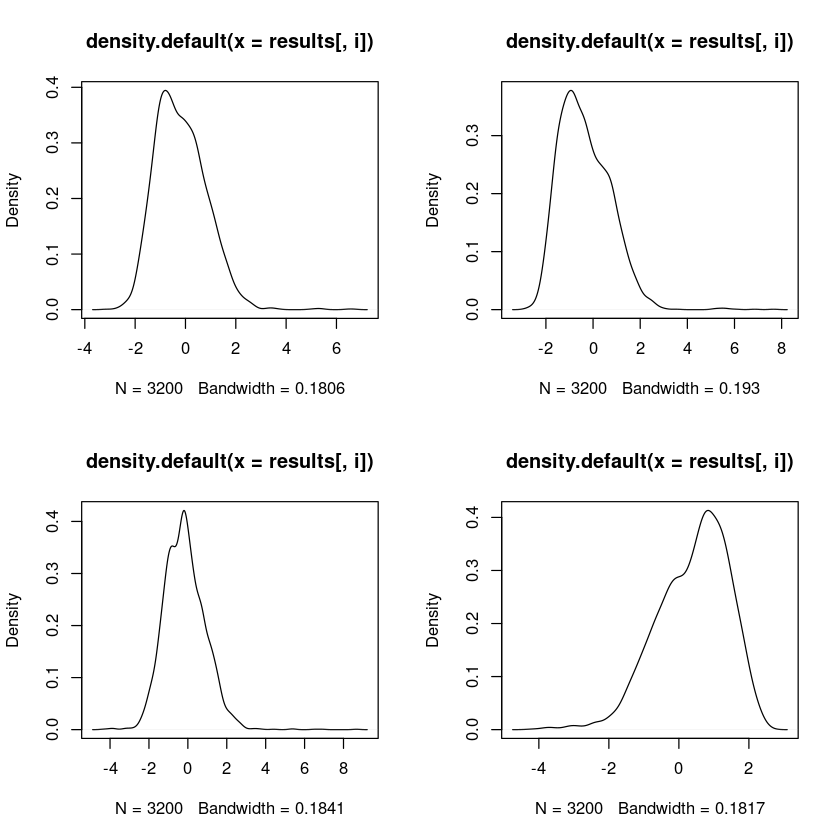

In [156]:
results <- predict(encoder, x_test, batch_size = 64) 
dim(results)
head(results)
apply(results, 2, summary)

par(mfrow = c(2, 2))
for (i in 1:4) {
    plot(density(results[, i]))
}
par(mfrow=c(1,1))

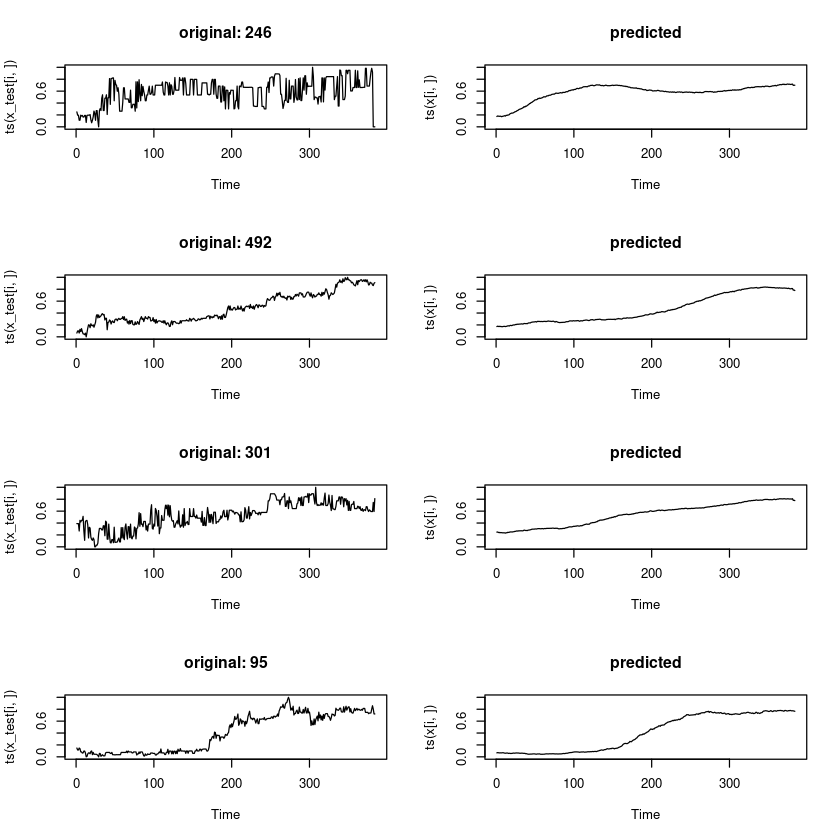

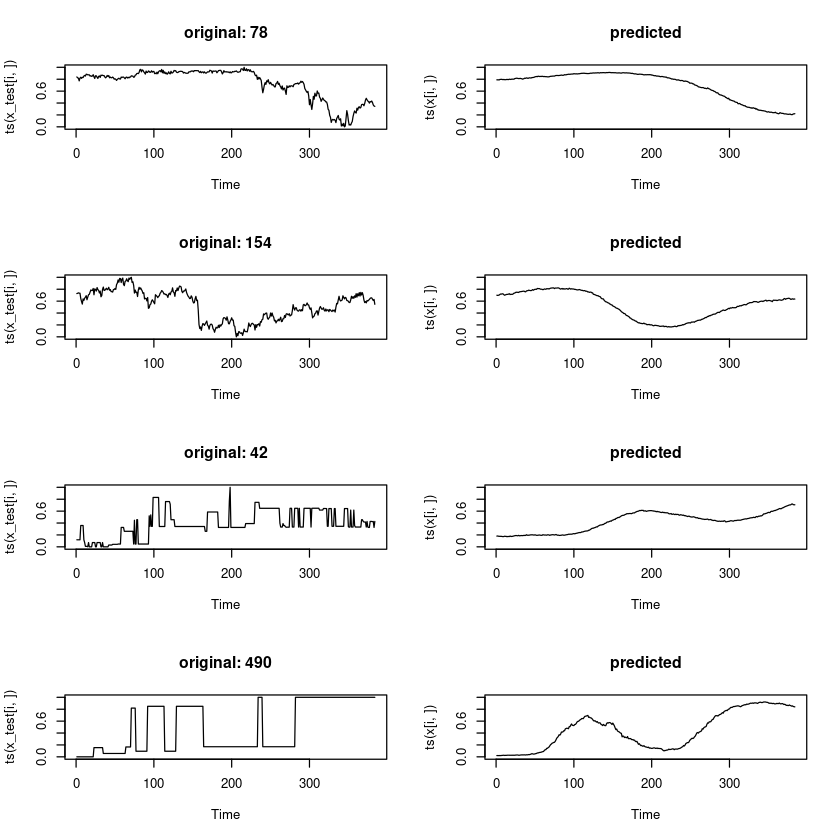

In [131]:
x<-predict(generator, results)

par(mfrow = c(4, 2))
for (i in sample(640, 8)) {
    plot(ts(x_test[i, ]), main = sprintf("original: %s", i), ylim = c(0, 1))
    plot(ts(x[i, ]), main = "predicted", ylim = c(0, 1))
} 
par(mfrow = c(1, 1))

According to the book (Deep Learning with R), the mebedded space should be continuous. This means, I can make a 4-D grid, generate syntethic Bitcoin from the model & then observe how bitcoin changes across the model's surface. Let's give this a go...

In [132]:
# plot 8 x 8 images across all dimensions ( a giant pairwise plot really )
grid <- seq(-4, 4, length.out = 16)
mygrid <- CJ(grid, grid, grid, grid)   # make a huge kx8 grid, which will be my input vectors...
dim(mygrid)
head(mygrid)
tail(mygrid)
apply(mygrid, 2, summary)
mygrid <- as.matrix(mygrid)


results <- predict(generator, mygrid[seq(1, nrow(mygrid), length.out = 65536), ])
head(results)

[1] 65536     4

V1,V2,V3,V4
-4,-4,-4,-4.000000
-4,-4,-4,-3.466667
-4,-4,-4,-2.933333
-4,-4,-4,-2.400000
-4,-4,-4,-1.866667
-4,-4,-4,-1.333333


V1,V2,V3,V4
4,4,4,1.333333
4,4,4,1.866667
4,4,4,2.400000
4,4,4,2.933333
4,4,4,3.466667
4,4,4,4.000000


,V1,V2,V3,V4
Min.,-4.000000e+00,-4.000000e+00,-4.000000e+00,-4.000000e+00
1st Qu.,-2.000000e+00,-2.000000e+00,-2.000000e+00,-2.000000e+00
Median,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Mean,2.168404e-19,-5.377643e-17,-2.775558e-17,-2.775558e-17
3rd Qu.,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
Max.,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00


0.0004584554,0.0004617346,0.0004797001,0.0005325536,0.0004294993,0.0005018612,0.0003635613,0.0004976520,0.0005234086,0.0005220427,⋯,0.9866809,0.9880999,0.9863272,0.9805447,0.9761617,0.9765010,0.9759002,0.9751621,0.9708280,0.9621037
0.0007257719,0.0007380989,0.0007599226,0.0008163425,0.0006624966,0.0007691544,0.0005575306,0.0007718325,0.0008008067,0.0008347780,⋯,0.9850595,0.9864584,0.9846593,0.9782325,0.9742575,0.9742222,0.9745237,0.9730008,0.9689310,0.9602362
0.0012145269,0.0012501202,0.0012804796,0.0013184494,0.0010978214,0.0012653171,0.0009223669,0.0012736813,0.0013057614,0.0014079314,⋯,0.9831185,0.9845637,0.9827009,0.9756892,0.9721548,0.9713869,0.9728959,0.9702147,0.9668628,0.9574264
0.0019906377,0.0020716025,0.0020888220,0.0020577612,0.0017700284,0.0020143613,0.0015124925,0.0020377405,0.0021028975,0.0023398709,⋯,0.9820399,0.9832326,0.9812243,0.9740531,0.9709401,0.9699712,0.9722243,0.9693444,0.9670976,0.9573225
0.0036786539,0.0038685072,0.0037285716,0.0035941044,0.0031716214,0.0034886801,0.0027032348,0.0035689841,0.0036816769,0.0040462571,⋯,0.9823041,0.9827647,0.9804317,0.9733160,0.9700922,0.9693078,0.9712991,0.9694636,0.9679900,0.9570652
0.0067947153,0.0070704734,0.0065352204,0.0061927051,0.0055842185,0.0059039085,0.0047431937,0.0061246040,0.0063118157,0.0068973321,⋯,0.9826351,0.9823982,0.9797721,0.9730016,0.9694750,0.9688458,0.9708135,0.9702194,0.9691673,0.9574956


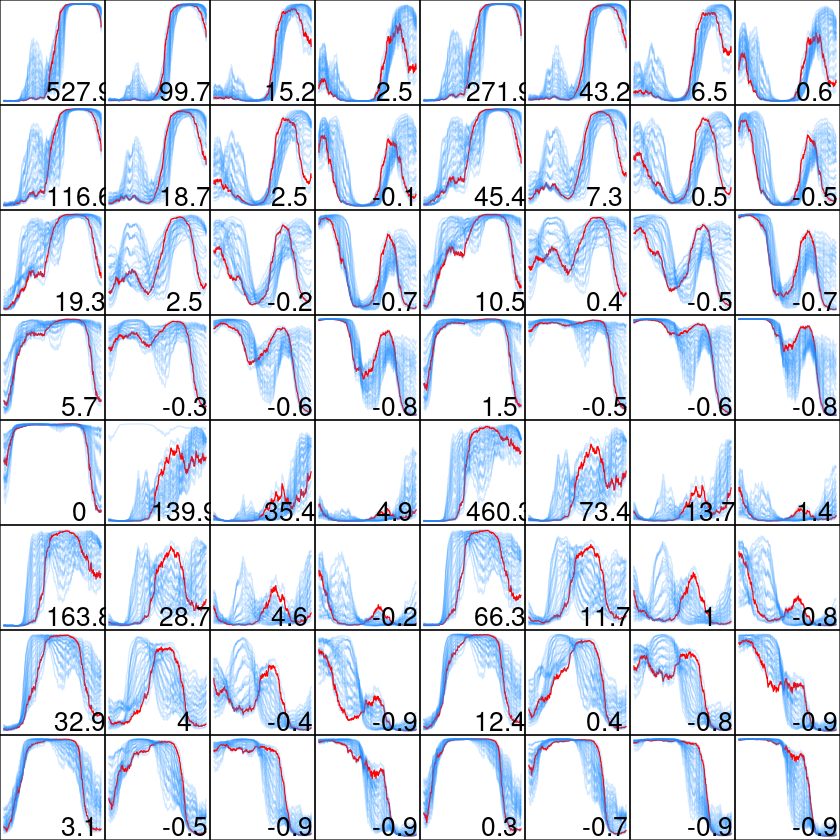

In [133]:
# I'm going to plot 32 images in one square
# meaning, I should be able to get 8*64 images on this
# so, I will step forwards by a 128 images at each step to make sure I cover the ground
par(mfrow = c(8, 8), mar = c(0,0,0,0))


for (i in 0:63) {
    start_ <-  i * 32 + 1
    end_ <- (i + 1)*32
    idx <- seq(1, 65536, length.out = 32*64)[start_:end_]
    #print(start_:end_)
    #print(idx)
    returns <- mean((results[idx, ncol(results)] - results[idx, 1]) / results[idx, 1])
    for (j in 1:length(idx)) {
        if (j == 1) {
            plot(results[idx[j], ], type = "l", ylim = c(0, 1), main = "", xlab = "", ylab = "",
                col = scales::alpha("dodgerblue", 0.2), xaxt = 'n', yaxt = 'n')
            
        } else if (j == 16) {
            lines(results[idx[j], ], col = "red")
        } else {
            lines(results[idx[j], ], col = scales::alpha("dodgerblue", 0.2))
        }
    }
    text(x = 300, y = 0.1, label = round(returns, 1), cex = 2)
}

One of the cool things you could do with this, is impute missing data. For example, let's randomly remove 20% of the values (i.e. a lot!) from the training set and then plot the VAE results:

impute_
     0      1 
983346 245454 

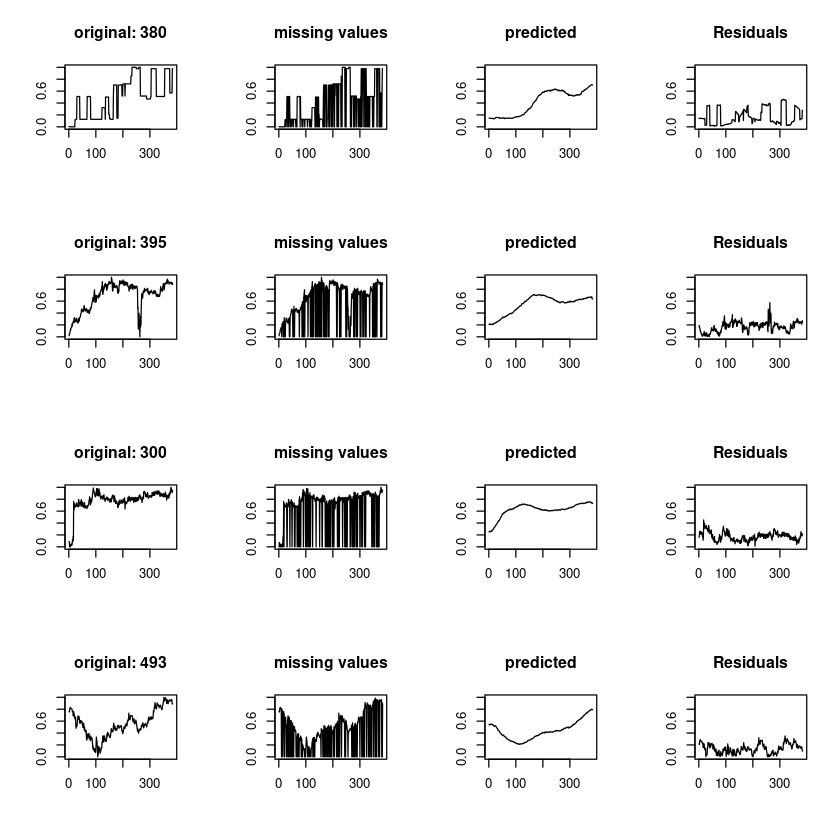

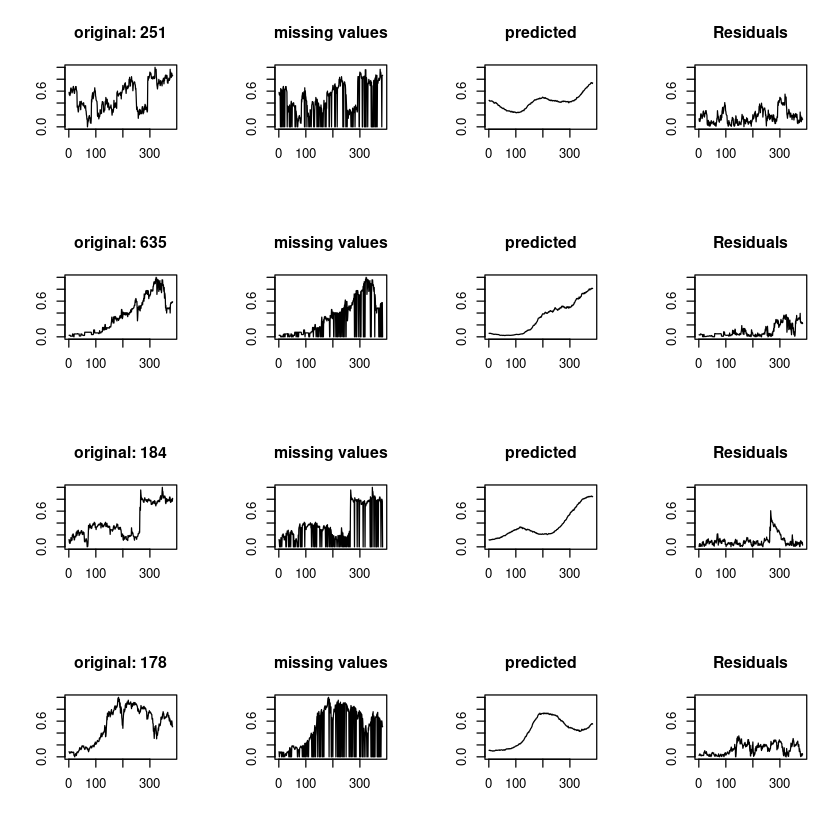

In [154]:
impute_ <- matrix(rbinom(nrow(x_test) * ncol(x_test), 1, 0.2), nrow = nrow(x_test))
table(impute_)

imputed_set <- x_test
imputed_set[impute_ == 1] <- 0
results <- predict(encoder, imputed_set, batch_size = 64)
x<-predict(generator, results)

par(mfrow = c(4, 4))
for (i in sample(640, 8)) {
    plot(ts(x_test[i, ]), main = sprintf("original: %s", i), ylim = c(0, 1), xlab="", ylab="")
    plot(ts(imputed_set[i, ]), main = "missing values", ylim = c(0, 1), xlab="", ylab="")
    plot(ts(x[i, ]), main = "predicted", ylim = c(0, 1), xlab="", ylab="")
    plot(ts(abs(x[i, ] - x_test[i, ])), main = "Residuals", ylim = c(0, 1), xlab="", ylab="")

} 
par(mfrow = c(1, 1))

That's actually pretty impressive. That is a lot of missing data, which has now been imputed in a way which preserves the data generation process from the training set. Or course, this makes complete sense, knowing how the algorithm works, the training set is somewhat irrelevant. But nonetheless, this is cool.

If you extend this thought process... you could use a VAE as a generative model which feeds an anomaly detection routine, i.e., what is the likelihood of observing this point, given the data generation model that we've trained? Hmmmm, cool.